## IMPORT LIBRARY

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


## LOAD DATA

In [33]:
df = pd.read_csv('../dataset/powerconsumption.csv')
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


## PREPROCESSING

In [35]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)

In [36]:
df.index.min(), df.index.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2017-12-30 23:50:00'))

In [37]:
df.index.to_series().diff().value_counts()

Datetime
0 days 00:10:00    52415
Name: count, dtype: int64

In [38]:
duplicates = df.index.duplicated().sum()
print("Jumlah waktu duplikat:", duplicates)

Jumlah waktu duplikat: 0


In [39]:
# buat range waktu lengkap berdasarkan min dan max index
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='10min')

# bandingkan panjangnya
print("Jumlah baris saat ini:", len(df))
print("Jumlah baris seharusnya:", len(full_range))

# cek apakah ada waktu yang hilang
missing_times = full_range.difference(df.index)
print("Jumlah timestamp hilang:", len(missing_times))

Jumlah baris saat ini: 52416
Jumlah baris seharusnya: 52416
Jumlah timestamp hilang: 0


## EXPLORATORY DATA ANALYSIS

In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,52416.0,18.810024,5.815476,3.247000,14.410000,18.780000,22.890000,40.01000
Humidity,52416.0,68.259518,15.551177,11.340000,58.310000,69.860000,81.400000,94.80000
WindSpeed,52416.0,1.959489,2.348862,0.050000,0.078000,0.086000,4.915000,6.48300
GeneralDiffuseFlows,52416.0,182.696614,264.400960,0.004000,0.062000,5.035500,319.600000,1163.00000
DiffuseFlows,52416.0,75.028022,124.210949,0.011000,0.122000,4.456000,101.000000,936.00000
PowerConsumption_Zone1,52416.0,32344.970564,7130.562564,13895.696200,26310.668692,32265.920340,37309.018185,52204.39512
PowerConsumption_Zone2,52416.0,21042.509082,5201.465892,8560.081466,16980.766032,20823.168405,24713.717520,37408.86076
PowerConsumption_Zone3,52416.0,17835.406218,6622.165099,5935.174070,13129.326630,16415.117470,21624.100420,47598.32636


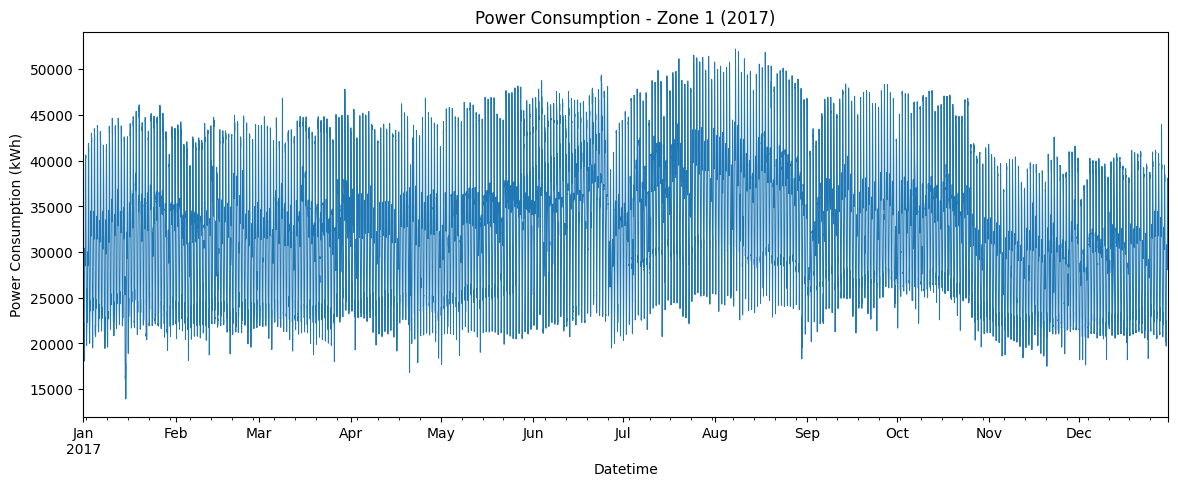

In [ ]:
plt.figure(figsize=(14, 5))
df['PowerConsumption_Zone1'].plot(linewidth=0.7)
plt.title('Power Consumption - Zone 1 (2017)')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption (kWh)')
plt.show()


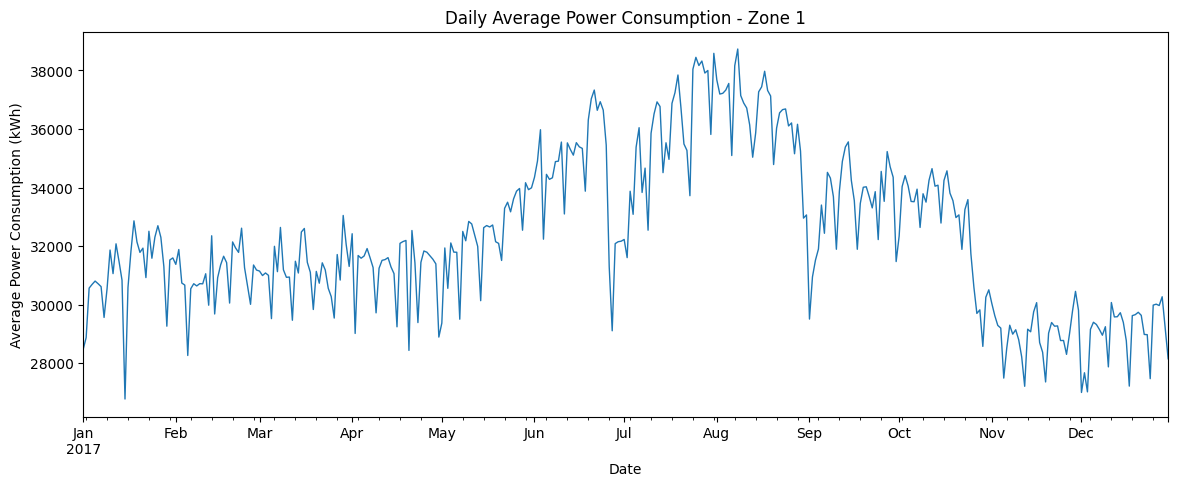

In [42]:
daily_power = df['PowerConsumption_Zone1'].resample('D').mean()

plt.figure(figsize=(14, 5))
daily_power.plot(color='tab:blue', linewidth=1)
plt.title('Daily Average Power Consumption - Zone 1')
plt.xlabel('Date')
plt.ylabel('Average Power Consumption (kWh)')
plt.show()


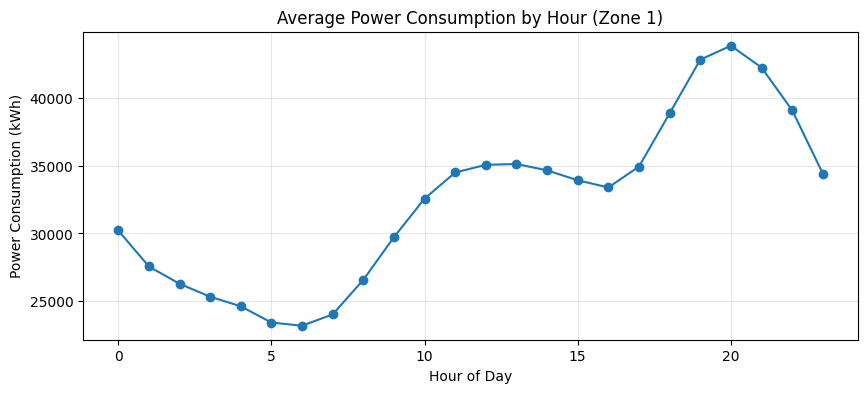

In [43]:
df['hour'] = df.index.hour
hourly_mean = df.groupby('hour')['PowerConsumption_Zone1'].mean()

plt.figure(figsize=(10,4))
hourly_mean.plot(marker='o')
plt.title('Average Power Consumption by Hour (Zone 1)')
plt.xlabel('Hour of Day')
plt.ylabel('Power Consumption (kWh)')
plt.grid(True, alpha=0.3)
plt.show()


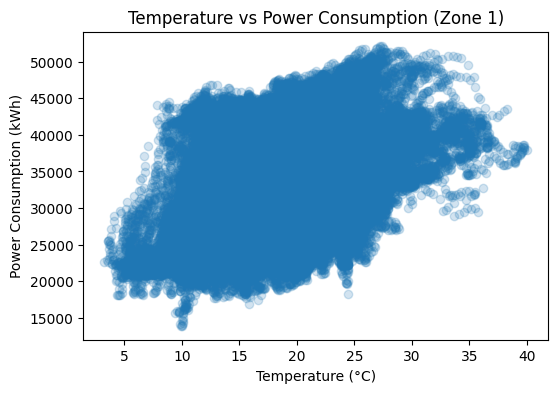

In [44]:
plt.figure(figsize=(6,4))
plt.scatter(df['Temperature'], df['PowerConsumption_Zone1'], alpha=0.2)
plt.title('Temperature vs Power Consumption (Zone 1)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Power Consumption (kWh)')
plt.show()


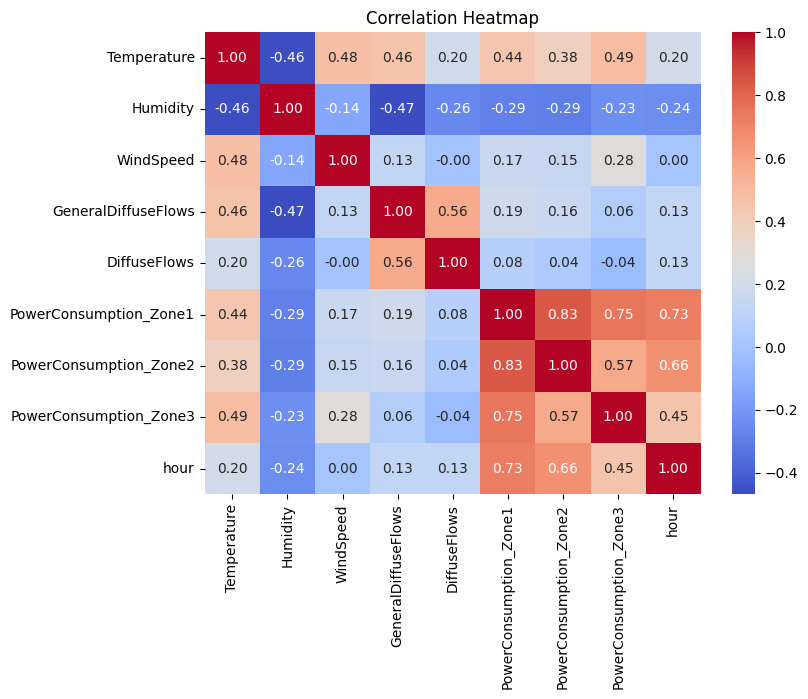

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


## FEATURE ENGINEERING

In [47]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek  # 0 = Senin, 6 = Minggu
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

In [48]:
df['lag_10min'] = df['PowerConsumption_Zone1'].shift(1)
df['lag_30min'] = df['PowerConsumption_Zone1'].shift(3)
df['lag_1h'] = df['PowerConsumption_Zone1'].shift(6)
df['lag_1d'] = df['PowerConsumption_Zone1'].shift(6*24)  # 24 jam = 144 titik, tapi 10 menit × 6 = 1 jam


In [49]:
df['rolling_1h'] = df['PowerConsumption_Zone1'].rolling(window=6).mean()
df['rolling_6h'] = df['PowerConsumption_Zone1'].rolling(window=6*6).mean()
df['rolling_24h'] = df['PowerConsumption_Zone1'].rolling(window=6*24).mean()


In [50]:
df.dropna(inplace=True)


In [51]:
df.columns

Index(['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2',
       'PowerConsumption_Zone3', 'hour', 'day', 'month', 'day_of_week',
       'is_weekend', 'lag_10min', 'lag_30min', 'lag_1h', 'lag_1d',
       'rolling_1h', 'rolling_6h', 'rolling_24h'],
      dtype='object')

## SPLIT DATASET

In [52]:
target = 'PowerConsumption_Zone1'

features = [
    'Temperature', 'Humidity', 'WindSpeed',
    'GeneralDiffuseFlows', 'DiffuseFlows',
    'hour', 'day', 'month', 'day_of_week', 'is_weekend',
    'lag_10min', 'lag_30min', 'lag_1h', 'lag_1d',
    'rolling_1h', 'rolling_6h', 'rolling_24h'
]

X = df[features]
y = df[target]


In [53]:
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


## BASELINE MODEL
1. LINEAR REGRESSION
2. XGBOOST REGRESSOR

In [ ]:
def eval_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n🚀 Training {name}...")
    # Train
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_test)
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    return y_pred, mae, rmse


# === Linear Regression ===
lr = LinearRegression()
lr_pred, mae_lr, rmse_lr = eval_model("Linear Regression", lr, X_train, y_train, X_test, y_test)

# === XGBoost ===
xgb = XGBRegressor()
xgb_pred, mae_xgb, rmse_xgb = eval_model("XGBoost", xgb, X_train, y_train, X_test, y_test)


🚀 Training Linear Regression...
MAE  : 216.86
RMSE : 319.84

🚀 Training XGBoost...
MAE  : 321.19
RMSE : 524.63


## PREDICTION VS ACTUAL COMPARISON VISUALIZATION

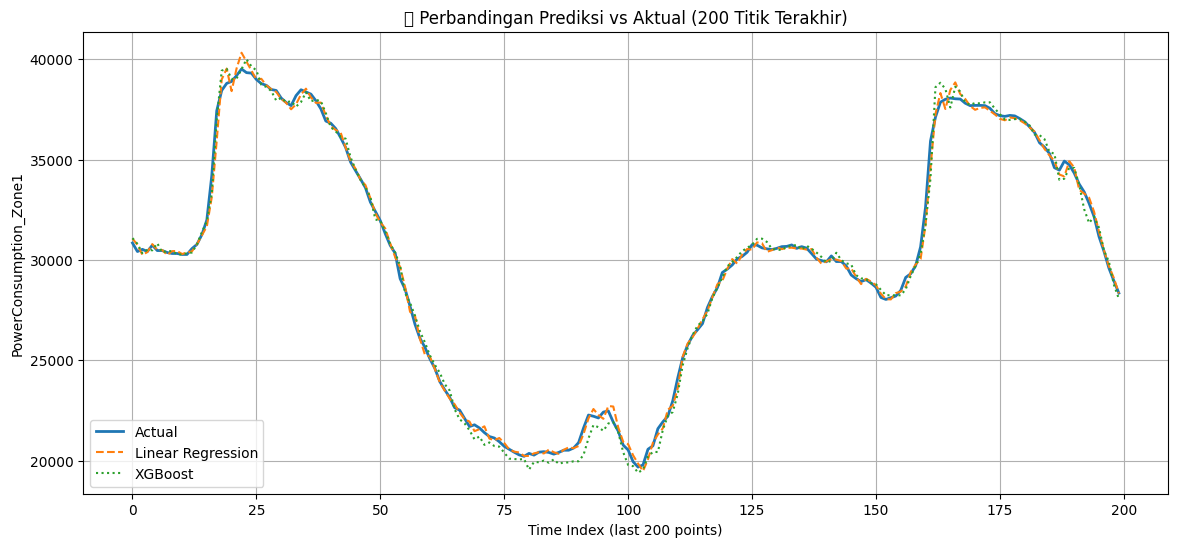

In [60]:
plt.figure(figsize=(14,6))
plt.plot(y_test[-200:].values, label='Actual', linewidth=2)
plt.plot(lr_pred[-200:], label='Linear Regression', linestyle='--')
plt.plot(xgb_pred[-200:], label='XGBoost', linestyle=':')
plt.title("🔌 Perbandingan Prediksi vs Aktual (200 Titik Terakhir)")
plt.xlabel("Time Index (last 200 points)")
plt.ylabel("PowerConsumption_Zone1")
plt.legend()
plt.grid(True)
plt.show()

## OPTIMIZATION XGBOOST - HYPERPARAMETER TUNING (RANDOMIZEDSEARCH)

In [ ]:
xgb_param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_lambda': [0.1, 1, 5],
    'reg_alpha': [0.1, 1, 5]
}

# === Randomized Search ===
xgb = XGBRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("🔍 Tuning XGBoost dengan RandomizedSearchCV...")
random_search.fit(X_train, y_train)

# === Model terbaik ===
best_xgb = random_search.best_estimator_
print("\n✅ Best Parameters (XGBoost):")
print(random_search.best_params_)

# === Evaluasi Model ===
y_pred_xgb = best_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"\n📊 Hasil Evaluasi XGBoost (setelah tuning):")
print(f"MAE  : {mae_xgb:.2f}")
print(f"RMSE : {rmse_xgb:.2f}")



🔍 Tuning XGBoost dengan RandomizedSearchCV...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

✅ Best Parameters (XGBoost):
{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}

📊 Hasil Evaluasi XGBoost (setelah tuning):
MAE  : 250.69
RMSE : 370.49


## EVALUATION

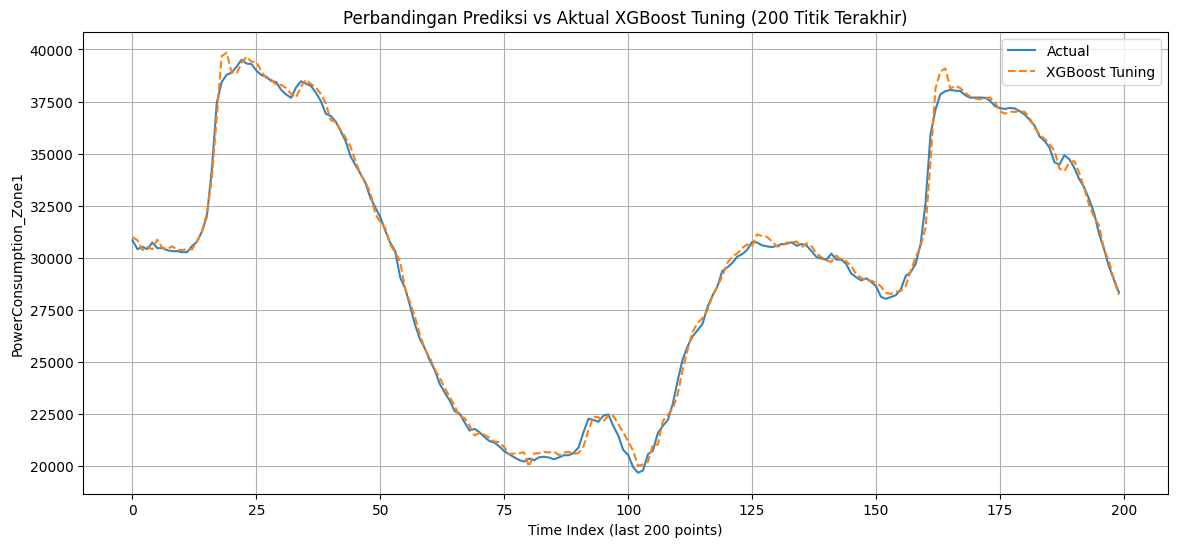

In [95]:
plt.figure(figsize=(14,6))
plt.plot(y_test[-200:].values, label='Actual', alpha=0.9)
plt.plot(y_pred_xgb[-200:], label='XGBoost Tuning', linestyle='--')
plt.title("Perbandingan Prediksi vs Aktual XGBoost Tuning (200 Titik Terakhir)")
plt.xlabel("Time Index (last 200 points)")
plt.ylabel("PowerConsumption_Zone1")
plt.legend()
plt.grid(True)
plt.show()